In [1]:
##### -*-coding:utf-8 -*-
# import all the libraries 
# python==3.8; jupyterlab==3.0.12; lumicks.pylake==0.8.1; matplotlib==3.3.4; more-itertools==8.7.0;
# npTDMS==1.1.0; numpy==1.20.1; opencv-python==4.5.1.48; pandas==1.2.3; scipy==1.6.1; tifffile==2021.3.5
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from matplotlib.colors import Normalize, LinearSegmentedColormap
import seaborn as sns
from scipy.interpolate import interp1d
from scipy import interpolate
# from __future__ import division
from more_itertools import chunked
# %matplotlib widget
%matplotlib inline

# Let's start by importing the processed data from the correlation step #2, and verify the correlation quality before conducting comprehensive analysis

In [2]:
# read the correlated force data and image data from step2:(2_Correlation_image_force).e.g.:cycle#1-correlated_data.xlsx
cor_file = 'example_dataset/image data/ChangePoints_Results/OTdata_example_30nM DNAp + trx  + 625uM dNTPs-cycle#01-processedData-correlated_analysis.xlsx'
cor_file2 = 'example_dataset/image data/results/image_data_example 30nM DNAp + trx  + 625uM dNTPs-cycle#1-Intensity_along_DNAp-filtered.txt' 
cor_file3 = 'example_dataset/image data/stepfinding_results/image_data_example 30nM DNAp + trx  + 625uM dNTPs-cycle#1-Intensity_along_DNAp-filtered_fit_trace.csv'

# read the correlated force data
raw_basepair = pd.read_excel(cor_file,sheet_name = 'raw_data')
cp_basepair = pd.read_excel(cor_file,sheet_name = 'change_points')
# read the correlated image data
raw_intensity = np.loadtxt(cor_file2)
filtered_intensity = np.genfromtxt(cor_file3, delimiter=',', skip_header=1)
step_intensity = pd.read_excel(cor_file,sheet_name = 'step_intensity')
binarized_intensity = pd.read_excel(cor_file,sheet_name = 'binarized_intensity')

# let's define these parameters for further analysis
time_intens = binarized_intensity['time_s']
time_intens = np.array(time_intens)
intensity_raw = raw_intensity.T[1]
intensity_filtered = filtered_intensity.T[1]
intensity = binarized_intensity['binarized_intensity']
intensity = np.array(intensity)
intensity_step = step_intensity['step_intensity']
intensity_step = np.array(intensity_step)

bp_time = raw_basepair['time_s']
bp_time = np.array(bp_time)
bp = raw_basepair['raw_basepair']
bp = np.array(bp)
cp_basepair_interp = pd.read_excel(cor_file,sheet_name = 'interpolated_data')['interpolated_basepair']
cp_basepair_interp = np.array(cp_basepair_interp)

# print(raw_basepair.head())
# print(cp_basepair.head())
# print(binarized_intensity.head())

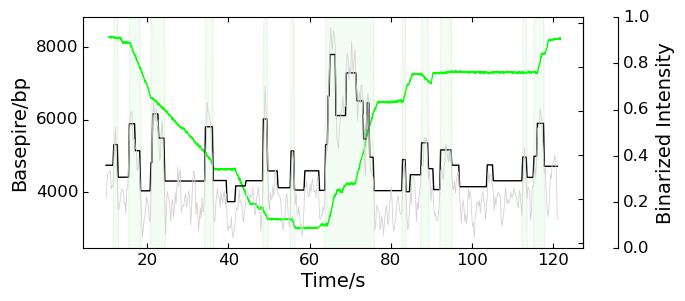

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'example_dataset/image data/ChangePoints_Results/OTdata_example_30nM DNAp + trx  + 625uM dNTPs-cycle#01-processedData-correlated_analysis.xlsx\\final_analysis'

<Figure size 640x480 with 0 Axes>

In [6]:
# plot the correlated force data and image data from step 2 to double check
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

plt.figure(figsize=(8,3))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()

offset = 25
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par2.axis["right"].toggle(all=True)

host.set_xlabel("Time/s",fontdict=font)
host.set_ylabel("Basepire/bp",fontdict=font)
# host.set_ylabel("DNAp Activity Burst")
par1.set_ylabel("Step-like Intensity",fontdict=font)
par2.set_ylabel("Binarized Intensity",fontdict=font)

p0, = host.plot(bp_time,bp, "lime",label = 'Basepairs',linewidth=1)

# p0, = host.plot(bp_time[:-1],np.diff(cp_basepair_interp)/np.diff(bp_time),"red", label = "DNAp Activity Burst",linewidth = 1)
p1, = par1.plot(time_intens,intensity_step,color='black',linewidth=1, label='Step-like intensity')
p2, = par2.plot(time_intens,intensity,color='lightgray',linewidth=0.1, label='Binarized Intensity')
par2.fill_between(time_intens,intensity, 0, color='lightgreen',alpha=0.1)
p3, = par3.plot(time_intens,intensity_raw,color='lightgray',linewidth=0.6, linestyle='solid', markersize=0.5,label='Raw Intensity')

host.autoscale()
host.margins(0.1)

# par1.axhline(np.average(bagrnd_signal_filter)+threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--',label=str(threshold_sigma) + ' Sigma threshold')
# par1.axhline(np.average(bagrnd_signal_filter)-threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--')

par1.set_ylim(10, 77)
par2.set_ylim(0, 1)

par2.axis["right"].label.set_color(p1.get_color())
par2.axis('off')
par1.yaxis.set_ticklabels([])
par1.yaxis.set_ticks([])

# plt.ylim(6500,7800)
# plt.xlim(17,29)
plt.show()
plt.tight_layout()

# Construct the desired output directory path
# Use both forward and backward slashes to handle cross-platform paths
cor_file_normalized = cor_file.replace('/', os.sep).replace('\\', os.sep)
root_dir = cor_file_normalized.split(os.sep)[0]  # Gets 'example_dataset'
output_dir = os.path.join(root_dir, 'final_analysis')
os.makedirs(output_dir, exist_ok=True)

# Generate the new filename by extracting the correct prefix
base_filename = os.path.basename(cor_file)
# Split the filename at the '#' symbol to remove cycle number and subsequent parts
name_prefix = base_filename.split('#')[0]

figure_filename = f"{name_prefix}-all_correlated_data-replot.eps"
figure_path = os.path.join(output_dir, figure_filename)

plt.savefig(figure_path, format='eps', dpi=300, bbox_inches='tight')
print(f"Replot figure saved to: {figure_path}")

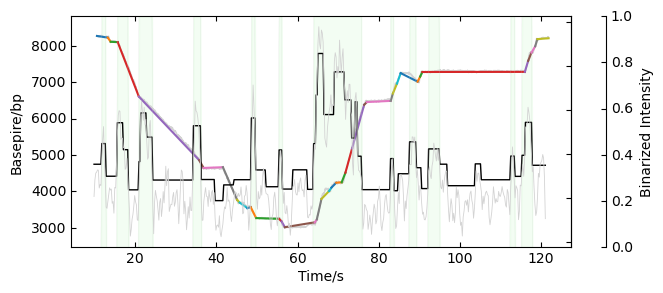

NameError: name 'name_prefix' is not defined

<Figure size 640x480 with 0 Axes>

In [4]:
# plot the correlated force data and image data from step 2 to double check
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

plt.figure(figsize=(8,3))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()

offset = 25
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par2.axis["right"].toggle(all=True)

host.set_xlabel("Time/s",fontdict=font)
host.set_ylabel("Basepire/bp",fontdict=font)
# host.set_ylabel("DNAp Activity Burst")
par1.set_ylabel("Step-like Intensity",fontdict=font)
par2.set_ylabel("Binarized Intensity",fontdict=font)

# Assuming 'cor_file' is defined and pandas is imported (e.g., import pandas as pd)
# cp_basepair = pd.read_excel(cor_file, sheet_name='change_points')

# Plot original data as a faint background line
host.plot(bp_time, bp, color="lightgray", label='_nolegend_', linewidth=1)

# Plot each detected segment with a different color
for index, row in cp_basepair.iterrows():
    host.plot([row['cp_startTime_s'], row['cp_endTime_s']],
              [row['cp_startBasepair'], row['cp_endBasepair']],
              linewidth=1.5)

# p0, = host.plot(bp_time,bp, "lime",label = 'Basepairs',linewidth=1)

p1, = par1.plot(time_intens,intensity_step,color='black',linewidth=1, label='Step-like intensity')
p2, = par2.plot(time_intens,intensity,color='lightgray',linewidth=0.1, label='Binarized Intensity')
par2.fill_between(time_intens,intensity, 0, color='lightgreen',alpha=0.1)
p3, = par3.plot(time_intens,intensity_raw,color='lightgray',linewidth=0.6, linestyle='solid', markersize=0.5,label='Raw Intensity')

host.autoscale()
host.margins(0.1)

# par1.axhline(np.average(bagrnd_signal_filter)+threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--',label=str(threshold_sigma) + ' Sigma threshold')
# par1.axhline(np.average(bagrnd_signal_filter)-threshold_sigma*np.std(bagrnd_signal_filter), color='grey', linestyle='--')

par1.set_ylim(10, 77)
par2.set_ylim(0, 1)

par2.axis["right"].label.set_color(p1.get_color())
par2.axis('off')
par1.yaxis.set_ticklabels([])
par1.yaxis.set_ticks([])

# plt.ylim(6500,7800)
# plt.xlim(17,29)
plt.show()
plt.tight_layout()

figure_filename = f"{name_prefix}-all_correlated_data-replot_ColoredRates.eps"
figure_path = os.path.join(output_dir, figure_filename)

plt.savefig(figure_path, format='eps', dpi=300, bbox_inches='tight')
print(f"Replot figure saved to: {figure_path}")

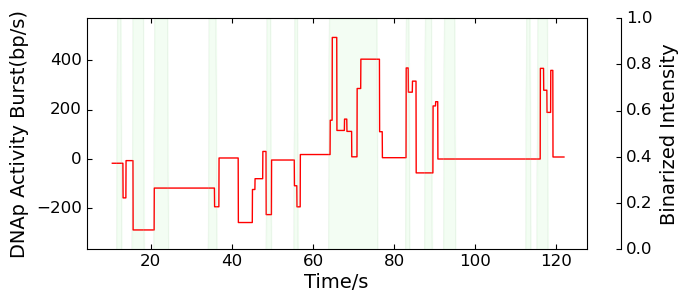

NameError: name 'name_prefix' is not defined

<Figure size 640x480 with 0 Axes>

In [5]:
# plot the burst activity and fluorescence image data 
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

plt.figure(figsize=(8,3))
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
# par3 = host.twinx()

offset = 25
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par2.axis["right"].toggle(all=True)

host.set_xlabel("Time/s")
host.set_ylabel("DNAp Activity Burst(bp/s)")
# par1.set_ylabel("Step-like Intensity",fontdict=font)
par2.set_ylabel("Binarized Intensity")

# p0, = host.plot(bp_time,bp, "lime",label = 'Basepairs',linewidth=1)

p0, = host.plot(bp_time[:-1],np.diff(cp_basepair_interp)/np.diff(bp_time),"red", label = "DNAp Activity Burst",linewidth = 1)
# p1, = par1.plot(time_intens,intensity_step,color='black',linewidth=1, label='Step-like intensity')
p2, = par2.plot(time_intens,intensity,color='lightgray',linewidth=0.1, label='Binarized Intensity')
par2.fill_between(time_intens,intensity, 0, color='lightgreen',alpha=0.1)
# p3, = par3.plot(time_intens,intensity_raw,color='lightgray',linewidth=0.6, linestyle='solid', markersize=0.5,label='Raw Intensity')

host.autoscale()
host.margins(0.1)

# par1.set_ylim(7, 87)
par2.set_ylim(0, 1)

par2.axis["right"].label.set_color(p1.get_color())
par2.axis('off')
par1.yaxis.set_ticklabels([])
par1.yaxis.set_ticks([])

# plt.xlim(32,40)
# plt.xlim(32,40)
# plt.close()
plt.show()
plt.tight_layout()

figure_filename = f"{name_prefix}-all_correlated_data-replot_Rate.eps"
figure_path = os.path.join(output_dir, figure_filename)

plt.savefig(figure_path, format='eps', dpi=300, bbox_inches='tight')
print(f"Replot_rate figure saved to: {figure_path}")

## the following code blocks are intended to find out the bound protein events, by splitting binarized intensity-time plots into sub-segments based on zero value

In [ ]:
# step 1: finding all the zero value points
index = np.where(intensity==0)[0]
index = np.insert(index,0,0)
index = np.append(index,len(intensity))
# print(index)
# print(len(index))

# step 2: creating sub-segments from one zero-value to next zero-value
time_list = []
for i, value in enumerate(index):
    try:
        time_lis = time_intens[index[i]:index[i+1]]
    except IndexError:
        pass
    time_list.append(time_lis)   
# print(time_list)

# step 3: filtering the sub-segments without or only 1 one-value, 
# which indicates no protein occurs or protein occurs for only one pixel time
# this returns the bound events!!
filter_dots = 2 # default value is 3
time_lst = [x for x in time_list if x.size > filter_dots]
# print(len(time_lst))

# step 4: calculating the starting time and ending time of the segments
start_time = []
end_time = []
for arr in time_lst:
    start_time.append(arr[1])
    end_time.append(arr[-1])

# start_time = start_time[:-1]
# end_time = end_time[:-1]

print(start_time)
print(end_time)

In [ ]:
# step 5: distinguish the exo and pol events based on force_transition_time
# force_transi_time = input('please type in the force transision time in s:' )
force_transi_time = 62.5
force_transi_time = float(force_transi_time)
# to find out whether protein presents during force transition
func_1 = interpolate.interp1d(time_intens,intensity,kind='slinear',fill_value="extrapolate")
force_transi_intensity = int(func_1(force_transi_time))
# print(force_transi_intensity)

start_time_exo = []
end_time_exo = []
start_time_pol = []
end_time_pol = []
if force_transi_intensity == 0: 
    for i,value in enumerate(end_time):
        if value < force_transi_time:
            start_time_exo.append(start_time[i])
            end_time_exo.append(value)
    for i,value in enumerate(start_time):
        if value > force_transi_time:
            start_time_pol.append(value)             
            end_time_pol.append(end_time[i]) 
    start_time_pol = start_time_pol[:]
    end_time_pol = end_time_pol[:]
        
if force_transi_intensity == 1:
    for i,value in enumerate(end_time):
        if value < force_transi_time:
            start_time_exo.append(start_time[i])
            end_time_exo.append(value)
    start_time_exo.append(start_time[len(start_time_exo)])
    end_time_exo.append(force_transi_time)
    for i,value in enumerate(start_time):
        if value > force_transi_time:
            start_time_pol.append(value)
            end_time_pol.append(end_time[i]) 
    try:
        end_time_pol.insert(0,end_time[len(end_time_exo)-1])  
    except IndexError:
        pass
    if len(end_time_pol) == 0:
        end_time_pol.insert(0,end_time[-1])
    start_time_pol.insert(0,force_transi_time)
    
print(start_time_exo)
print(end_time_exo)
print(start_time_pol)
print(end_time_pol)

In [ ]:
# step 6.1: distinguish the bound events and unbound events in exo and pol, respectively
# to calculate the dark events in exo region
dark_exo_start = []
dark_exo_end = []
if intensity[0] == 1 and force_transi_intensity == 0: #start with bound protein but lost during force transition 
    for i,value in enumerate(end_time_exo):
        try:
            dark_exo_start.append(value)
            dark_exo_end.append(start_time_exo[i+1])        
        except IndexError:
            pass
    dark_exo_end.append(force_transi_time)
    
if intensity[0] == 1 and force_transi_intensity == 1: #start with bound protein and have protein bound during force transition 
    for i,value in enumerate(end_time_exo):
        try:
            dark_exo_start.append(value)
            dark_exo_end.append(start_time_exo[i+1])        
        except IndexError:
            pass
    dark_exo_start = dark_exo_start[:-1]
    dark_exo_end = dark_exo_end[:]
    
if intensity[0] == 0 and force_transi_intensity == 0: #start without protein and have no protein bound during force transition 
    for i,value in enumerate(start_time_exo):
        try:        
            dark_exo_end.append(value)
            dark_exo_start.append(end_time_exo[i])
        except IndexError:
            pass
    dark_exo_start.insert(0,start_time_exo[0])
    dark_exo_end.append(force_transi_time)
    
if intensity[0] == 0 and force_transi_intensity == 1: #start without protein and have protein bound during force transition 
    for i,value in enumerate(start_time_exo):
        try:        
            dark_exo_end.append(value)
            dark_exo_start.append(end_time_exo[i])
        except IndexError:
            pass
    dark_exo_start.insert(0,start_time_exo[0])
    dark_exo_start = dark_exo_start[:-1]
    
print (dark_exo_start)
print (dark_exo_end)

In [ ]:
# step 6.2: distinguish the bound events and unbound events in exo and pol, respectively
# to calculate the dark events in pol regin   
dark_pol_start = []
dark_pol_end = []
if intensity[-1] == 1 and force_transi_intensity == 0: #end with bound protein but have no protein bound during force transition 
    for i,value in enumerate(start_time_pol):
        try:
            dark_pol_end.append(value)
            dark_pol_start.append(end_time_pol[i])        
        except IndexError:
            pass
    dark_pol_start.insert(0,force_transi_time)
    dark_pol_start = dark_pol_start[:-1]
    
if intensity[-1] == 1 and force_transi_intensity == 1: #end with bound protein and have protein bound during force transition 
    for i,value in enumerate(end_time_pol):
        try:
            dark_pol_start.append(value)
            dark_pol_end.append(start_time_pol[i+1])        
        except IndexError:
            pass
    dark_pol_start = dark_pol_start[:-2]
    dark_pol_end = dark_pol_end[:-1]
    
if intensity[-1] == 0 and force_transi_intensity == 0: #end without protein and have no protein bound during force transition 
    for i,value in enumerate(start_time_pol):
        try:        
            dark_pol_end.append(value)
            dark_pol_start.append(end_time_pol[i])
        except IndexError:
            pass
    dark_pol_start.insert(0,force_transi_time)
    dark_pol_end.append(end_time_pol[-1])
    
if intensity[-1] == 0 and force_transi_intensity == 1: #end without protein but have protein bound during force transition 
    for i,value in enumerate(end_time_pol):
        try:
            dark_pol_start.append(value)
            dark_pol_end.append(start_time_pol[i+1])        
        except IndexError:
            pass
    dark_pol_end.append(end_time_pol[-1])

print (dark_pol_start)
print (dark_pol_end)

In [ ]:
# pause

In [ ]:
# the following code block is intended to calculate the rates(slopes), iterating all the sub-segments

# this re-defination is because I am using the codes I wrote before
time = np.round(bp_time,3)
basepairs = np.round(bp,3)
# basepairs = np.round(cp_basepair_interp,3)

rate_bound_exo = []
rate_bound_pol = []
rate_unbound_exo = []
rate_unbound_pol = []

for i,value in enumerate(start_time_exo): 
    time_from_i = value
    time_to_i = end_time_exo[i]
    indtemp = np.where((time <= time_to_i) & (time >= time_from_i))
    time_ROI = time[indtemp]
    basepairs_ROI = basepairs[indtemp]
    try:
        duration_time = time_ROI[-1] - time_ROI[0]
        processivity = basepairs_ROI[-1] - basepairs_ROI[0]
    except IndexError:
        pass
    rate_i = processivity/duration_time
    rate_bound_exo = np.append(rate_bound_exo, rate_i)

for i,value in enumerate(start_time_pol): 
    time_from_i = value
    time_to_i = end_time_pol[i]
    indtemp = np.where((time <= time_to_i) & (time >= time_from_i))
    time_ROI = time[indtemp]
    basepairs_ROI = basepairs[indtemp]
    try:
        duration_time = time_ROI[-1] - time_ROI[0]
        processivity = basepairs_ROI[-1] - basepairs_ROI[0]
    except IndexError:
        pass
    rate_i = processivity/duration_time
    rate_bound_pol = np.append(rate_bound_pol, rate_i)

for i,value in enumerate(dark_exo_start): 
    time_from_i = value
    time_to_i = dark_exo_end[i]
    indtemp = np.where((time <= time_to_i) & (time >= time_from_i))
    time_ROI = time[indtemp]
    basepairs_ROI = basepairs[indtemp]
    try:
        duration_time = time_ROI[-1] - time_ROI[0]
        processivity = basepairs_ROI[-1] - basepairs_ROI[0]
    except IndexError:
        pass
    rate_i = processivity/duration_time
    rate_unbound_exo = np.append(rate_unbound_exo, rate_i)

for i,value in enumerate(dark_pol_start): 
    time_from_i = value
    time_to_i = dark_pol_end[i]
    indtemp = np.where((time <= time_to_i) & (time >= time_from_i))
    time_ROI = time[indtemp]
    basepairs_ROI = basepairs[indtemp]
    try:
        duration_time = time_ROI[-1] - time_ROI[0]
        processivity = basepairs_ROI[-1] - basepairs_ROI[0]
    except IndexError:
        pass
    rate_i = processivity/duration_time
    rate_unbound_pol = np.append(rate_unbound_pol, rate_i)
    
print(rate_bound_exo)
print(rate_bound_pol)
print(rate_unbound_exo) 
print(rate_unbound_pol)

In [ ]:
# Save all the analyzed data in an excel file

# Construct the desired output directory path
# Use both forward and backward slashes to handle cross-platform paths
cor_file_normalized = cor_file.replace('/', os.sep).replace('\\', os.sep)
root_dir = cor_file_normalized.split(os.sep)[0]  # Gets 'example_dataset'
output_dir = os.path.join(root_dir, 'final_analysis')
os.makedirs(output_dir, exist_ok=True)

# Generate the new filename by extracting the correct prefix
base_filename = os.path.basename(cor_file)
# Split the filename at the '#' symbol to remove cycle number and subsequent parts
name_prefix = base_filename.split('#')[0]
excel_filename = f"{name_prefix}-SegmentedTrack.xlsx"

excel_path = os.path.join(output_dir, excel_filename)

# Helper function to safely create DataFrames, handling potential empty lists
def create_df_safely(data_dict, sheet_name, writer):
    # Check if all arrays/lists in the dictionary have the same length
    it = iter(data_dict.values())
    the_len = len(next(it))
    if not all(len(l) == the_len for l in it):
        print(f"Warning: Mismatched lengths in data for sheet '{sheet_name}'. Skipping.")
        return

    # Check for non-empty DataFrame before writing
    if the_len > 0:
        df = pd.DataFrame(data_dict)
        df.to_excel(writer, sheet_name=sheet_name, index=False)
    else:
        print(f"Info: No data to write for sheet '{sheet_name}'.")

# Use a 'with' statement for the ExcelWriter for safer file handling
with pd.ExcelWriter(excel_path) as writer:
    # --- Sheet 1: all_bound_tracks ---
    if start_time and len(start_time) > 1:
        data_0 = {
            'track_Nmr': np.arange(1, len(start_time)),
            'start_time/s': start_time[:-1],
            'end_time/s': end_time[:-1],
            'track_duration/s': (np.array(end_time) - np.array(start_time))[:-1]
        }
        create_df_safely(data_0, 'all_bound_tracks', writer)

    # --- Sheet 2: bound_exo_track ---
    data_1 = {
        'track_Nmr': np.arange(1, len(start_time_exo) + 1),
        'start_time/s': start_time_exo,
        'end_time/s': end_time_exo,
        'track_duration/s': (np.array(end_time_exo) - np.array(start_time_exo)),
        'track_rate': rate_bound_exo
    }
    create_df_safely(data_1, 'bound_exo_track', writer)

    # --- Sheet 3: bound_pol_track ---
    data_2 = {
        'track_Nmr': np.arange(1, len(start_time_pol) + 1),
        'start_time/s': start_time_pol,
        'end_time/s': end_time_pol,
        'track_duration/s': (np.array(end_time_pol) - np.array(start_time_pol)),
        'track_rate': rate_bound_pol
    }
    create_df_safely(data_2, 'bound_pol_track', writer)

    # --- Sheet 4: dark_exo_track ---
    data_3 = {
        'track_Nmr': np.arange(1, len(dark_exo_start) + 1),
        'dark_exo_start/s': dark_exo_start,
        'dark_exo_end/s': dark_exo_end,
        'track_duration/s': (np.array(dark_exo_end) - np.array(dark_exo_start)),
        'track_rate': rate_unbound_exo
    }
    create_df_safely(data_3, 'dark_exo_track', writer)

    # --- Sheet 5: dark_pol_track ---
    data_4 = {
        'track_Nmr': np.arange(1, len(dark_pol_start) + 1),
        'dark_pol_start/s': dark_pol_start,
        'dark_pol_end/s': dark_pol_end,
        'dark_track_duration/s': (np.array(dark_pol_end) - np.array(dark_pol_start)),
        'track_rate': rate_unbound_pol
    }
    create_df_safely(data_4, 'dark_pol_track', writer)

print(f"Segmented track data saved to: {excel_path}")

In [ ]:
# In order to map the DNAp events, all the visualized DNAp are extracted with additional dark time (1.5s in this case) before- and afterwards
# Therefore, this code block is intended to analyze the bound events in addtion to two- 1.5s segments beforewards and afterwards
# why 1.5? average on time + average off time roughly equals 1.5s
dark_segment_time = 1.5
start_time_exo_segment = np.array(start_time_exo) - dark_segment_time
end_time_exo_segment = np.array(end_time_exo) + dark_segment_time
start_time_pol_segment = np.array(start_time_pol) - dark_segment_time
end_time_pol_segment = np.array(end_time_pol) + dark_segment_time

# print(start_time_exo_segment)
# print(start_time_pol_segment)

In [ ]:
# the following code block is intended to extract and visualize the DNAp bound events, iterating all the sub-segments

# this re-defination is because I am using the codes I wrote before
time = np.round(bp_time,3)
basepairs = np.round(bp,3)
basepairs_fitted = np.round(cp_basepair_interp,3)
# intensity = np.round(intensity,3)

segment_exo = []
segment_pol = []

#the data structure of segment_exo and segment_pol is: time_ROI,basepairs_ROI,basepairs_fitted_ROI,time_intens_ROI,intensity_ROI
# this code block is intended to distinguish the exo segments (exo events + 3s)
for i,value in enumerate(start_time_exo_segment): 
    time_from_i = value
    time_to_i = end_time_exo_segment[i]
    indtemp = np.where((time <= time_to_i) & (time >= time_from_i))
    indtemp2 = np.where((time_intens <= time_to_i) & (time_intens >= time_from_i))
    try:
        time_ROI = time[indtemp]
        basepairs_ROI = basepairs[indtemp]
        basepairs_fitted_ROI = basepairs_fitted[indtemp]
        time_intens_ROI = time_intens[indtemp2]
        intensity_ROI = intensity[indtemp2]
        intensity_step_ROI = intensity_step[indtemp2]
        intensity_raw_ROI = intensity_raw[indtemp2]
    except IndexError:
        pass
    force_data_exo = np.vstack((time_ROI,basepairs_ROI,basepairs_fitted_ROI)).T
    image_data_exo = np.vstack((time_intens_ROI,intensity_ROI,intensity_step_ROI,intensity_raw_ROI)).T
    segment_inexo = np.array([force_data_exo,image_data_exo],dtype=object)
    segment_exo.append(segment_inexo)
# this code block is intended to distinguish the pol segments (pol events + 3s)
for i,value in enumerate(start_time_pol_segment): 
    time_from_i = value
    time_to_i = end_time_pol_segment[i]
    indtemp = np.where((time <= time_to_i) & (time >= time_from_i))
    indtemp2 = np.where((time_intens <= time_to_i) & (time_intens >= time_from_i))
    try:
        time_ROI = time[indtemp]
        basepairs_ROI = basepairs[indtemp]
        basepairs_fitted_ROI = basepairs_fitted[indtemp]
        time_intens_ROI = time_intens[indtemp2]
        intensity_ROI = intensity[indtemp2]
        intensity_step_ROI = intensity_step[indtemp2]
        intensity_raw_ROI = intensity_raw[indtemp2]
    except IndexError:
        pass
    force_data_pol = np.vstack((time_ROI,basepairs_ROI,basepairs_fitted_ROI)).T
    image_data_pol = np.vstack((time_intens_ROI,intensity_ROI,intensity_step_ROI,intensity_raw_ROI)).T
    segment_inpol = np.array([force_data_pol,image_data_pol],dtype=object)
    segment_pol.append(segment_inpol)
# print (len(time_segment_exo[0]))
# print(len(intensity_segment_exo[0]))
print(len(segment_exo))
print(len(segment_pol))

# # the following block is intended to save the dada set
exo_npy_path = os.path.join(output_dir, f"{name_prefix}-exo-segments.npy")
np.save(exo_npy_path, segment_exo, allow_pickle=True)
print(f"Exo segments saved to: {exo_npy_path}")

pol_npy_path = os.path.join(output_dir, f"{name_prefix}-pol-segments.npy")
np.save(pol_npy_path, segment_pol, allow_pickle=True)
print(f"Pol segments saved to: {pol_npy_path}")


In [ ]:
# This step is to get a three y-axis figure, which shows basepairs, raw intensity and binarized intensity [https://matplotlib.org/3.4.3/gallery/ticks_and_spines/multiple_yaxis_with_spines.html]
def segment_plots(segment, ax=None, plt_kwargs={}, sct_kwargs={}):
    if ax is None:
        ax = plt.gca()
        
    time_ROI = segment[0][:,0]
    basepairs_ROI = segment[0][:,1]
    basepairs_fitted_ROI = segment[0][:,2]
    
    time_intens_ROI = segment[1][:,0]
    intensity_ROI = segment[1][:,1]
    intensity_step_ROI = segment[1][:,2]
    intensity_raw_ROI = segment[1][:,3]
    
    twin1 = ax.twinx()
    twin2 = ax.twinx()
    twin3 = ax.twinx()
    
    # Offset the right spine of twin2.  The ticks and label have already been
    # placed on the right by twinx above.
    # twin3.spines.right.set_position(("axes", 1.15))
    
    ax.plot(time_ROI,basepairs_fitted_ROI,"black", label = "step fitted data",linewidth=1)
    ax.plot(time_ROI,basepairs_ROI,"lightgrey",label = "raw data",linewidth=0.5)
    
    ax.set_xlabel('Time/s')
    ax.set_ylabel('Basepairs')
    ax.set_xlim(segment[0][:,0][0],segment[0][:,0][-1])

    
    twin1.plot(time_intens_ROI,intensity_raw_ROI,color='lightgreen',linewidth=0.5)
    twin2.plot(time_intens_ROI,intensity_step_ROI,color='green',linewidth=1)
    # twin3.plot(time_intens_ROI,intensity_ROI,color='lightgrey',linewidth=0.5)
    twin1.yaxis.set_ticklabels([])
    twin3.yaxis.set_ticklabels([])
    twin1.yaxis.set_ticks([])
    twin3.yaxis.set_ticks([])

    twin2.set_ylabel('Fluorescence Intensity (a.u.)')
    twin3.set_ylim(0.02,1.05)
    twin3.fill_between(time_intens_ROI,intensity_ROI, 0,step = "pre", alpha=0.2)

    return(ax)

# # segment_plots(segment_exo[0]).figure
# plt.figure(figsize=(6,4))
# segment_plots(segment_exo[1])
# plt.tight_layout()
# plt.show()

In [ ]:
# define a function to plot the the 1st derivative correlates with the fluorescence signal, to get the figure"Activity Burst Correlates with Fluorescence Signal"
def segment_rate_plots(segment, ax=None, plt_kwargs={}, sct_kwargs={}):
    if ax is None:
        ax = plt.gca()
        
    time_ROI = segment[0][:,0]
    basepairs_ROI = segment[0][:,1]
    basepairs_fitted_ROI = segment[0][:,2]
    
    time_intens_ROI = segment[1][:,0]
    intensity_ROI = segment[1][:,1]
    intensity_step_ROI = segment[1][:,2]
    intensity_raw_ROI = segment[1][:,3]
    # rate_ROI = (basepairs_fitted_ROI[2:] - basepairs_fitted_ROI[:-2])/(time_ROI[2:] - time[:-2])
    
    ax1 = ax.twinx()
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    
    ax.plot(time_ROI[:-1],np.diff(basepairs_fitted_ROI)/np.diff(time_ROI),"red", label = "step fitted data",linewidth=1)
    # ax.plot(time_ROI[:-2],rate_ROI,"red", label = "step fitted data",linewidth=1)
    ax.set_xlabel('Time/s')
    ax.set_ylabel('Activity Burst(bp/s)')
    ax.set_xlim(segment[0][:,0][0],segment[0][:,0][-1])
    ax1.plot(time_intens_ROI,intensity_raw_ROI,color='lightgreen',linewidth=0.5)
    ax3.plot(time_intens_ROI,intensity_step_ROI,color='green',linewidth=0.5)
    ax1.set_ylabel('Fluorescence Intensity (a.u.)')
    ax2.set_ylim(0.02,1.05)
    ax2.fill_between(time_intens_ROI,intensity_ROI, 0,step = "pre", alpha=0.1)
    ax2.yaxis.set_ticklabels([])
    ax2.yaxis.set_ticks([])
    ax3.yaxis.set_ticklabels([])
    ax3.yaxis.set_ticks([])
    # plt.show()
    # ax.plot(x, y, **plt_kwargs) #example plot1
    # ax.scatter(x, y, **sct_kwargs) #example plot2
    return(ax)


In [ ]:
# pause

In [ ]:
nrows_exo = 2
ncols_exo = 3

fig, axs = plt.subplots(nrows_exo,ncols_exo, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .8, wspace=.3)
fig.suptitle('Exo Segments')
data = np.arange(0, len(segment_exo))

for ax, d in zip(axs.ravel(), data):
    segment_plots(segment_exo[d],ax)
    fig.tight_layout()

# Construct the output path using the variables from the previous cell
figure_filename = f"{name_prefix}-exo-segments.png"
figure_path = os.path.join(output_dir, figure_filename)

fig.savefig(figure_path, dpi=300)
print(f"Exo segments figure saved to: {figure_path}")

In [ ]:
nrows_pol = 2
ncols_pol = 4

fig, axs = plt.subplots(nrows_pol,ncols_pol, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .8, wspace=.3)
fig.suptitle('Pol Segments')
data = np.arange(0, len(segment_pol))

for ax, d in zip(axs.ravel(), data):
    segment_plots(segment_pol[d],ax)
    fig.tight_layout()

figure_filename = f"{name_prefix}-pol-segments.png"
figure_path = os.path.join(output_dir, figure_filename)

fig.savefig(figure_path, dpi=300)
print(f"Pol segments figure saved to: {figure_path}")

In [ ]:
fig, axs = plt.subplots(nrows_exo,ncols_exo, figsize=(12, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .8, wspace=.3)
fig.suptitle('Exo Segments Activity Burst Rate')
data = np.arange(0, len(segment_exo))

for ax, d in zip(axs.ravel(), data):
    segment_rate_plots(segment_exo[d],ax)
    fig.tight_layout()
    
figure_filename = f"{name_prefix}-exo-segments-rate.png"
figure_path = os.path.join(output_dir, figure_filename)

fig.savefig(figure_path, dpi=300)
print(f"Exo segments rate figure saved to: {figure_path}")

In [ ]:
fig, axs = plt.subplots(nrows_pol,ncols_pol, figsize=(12,4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .8, wspace=.3)
fig.suptitle('Pol Segments Activity Burst Rate')
data = np.arange(0, len(segment_pol))

for ax, d in zip(axs.ravel(), data):
    segment_rate_plots(segment_pol[d],ax)
    fig.tight_layout()

figure_filename = f"{name_prefix}-pol-segments-rate.png"
figure_path = os.path.join(output_dir, figure_filename)

fig.savefig(figure_path, dpi=300)
print(f"Pol segments rate figure saved to: {figure_path}")

# We start to plot the correlation heatmap

In [ ]:
# We define a customerized correlation facor based on the combination of fluorescence and protein activity, and plot it out
# in total we get four combinations: [0,0];[0,1];[1,0];[1,1]

df_activity_data = pd.DataFrame({'Time': bp_time[:-1], 'Activity': np.diff(cp_basepair_interp)/np.diff(bp_time)})

bins = [-np.inf, -15, 20, np.inf]
labels = [1, 0, 1]
df_activity_data['BinarizedActivity'] = pd.cut(df_activity_data['Activity'], bins=bins, labels=labels, ordered=False)

df_intensity_data = pd.DataFrame({'Time': time_intens, 'Intensity': intensity})

f = interp1d(df_activity_data['Time'], df_activity_data['BinarizedActivity'], bounds_error=False, fill_value="extrapolate")
df_activity_data_interpolated = pd.DataFrame({'Time': df_intensity_data['Time'], 
                                              'InterpolatedBinarizedActivity': f(df_intensity_data['Time'])})

# Merging the two dataframes
df_merged = pd.merge(df_intensity_data, df_activity_data_interpolated, on='Time')

# Add custom correlation column
conditions = [
    (df_merged['Intensity'] == 1) & (df_merged['InterpolatedBinarizedActivity'] == 1),
    (df_merged['Intensity'] == 0) & (df_merged['InterpolatedBinarizedActivity'] == 0),
    (df_merged['Intensity'] == 0) & (df_merged['InterpolatedBinarizedActivity'] == 1),
    (df_merged['Intensity'] == 1) & (df_merged['InterpolatedBinarizedActivity'] == 0),
]
values = [1, -1, 0.5, -0.5]

df_merged['CustomCorrelation'] = np.select(conditions, values)
print(df_merged)

In [ ]:
# We plot the correlation heatmap

# Define the size of the matrix
matrix_size = len(df_merged)

# Initialize an empty square matrix filled with zeros
matrix = np.zeros((matrix_size, matrix_size))

# Fill the diagonal from bottom-left to top-right with 'CustomCorrelation'
prev_val = df_merged['CustomCorrelation'].iat[0]
start_idx = 0
for idx, row in df_merged.iterrows():
    curr_val = row['CustomCorrelation']
    if curr_val != prev_val:
        end_idx = idx
        if np.all(matrix[matrix_size - end_idx:matrix_size - start_idx, start_idx:end_idx] == 0):
            matrix[matrix_size - end_idx:matrix_size - start_idx, start_idx:end_idx] = prev_val
        start_idx = idx
    prev_val = curr_val

# Handle the last group
if np.all(matrix[matrix_size - matrix_size:matrix_size - start_idx, start_idx:matrix_size] == 0):
    matrix[matrix_size - matrix_size:matrix_size - start_idx, start_idx:matrix_size] = prev_val

# Flip the matrix to make the y-axis ascending from bottom to top
matrix_flipped = np.flip(matrix, 0)

cmap = LinearSegmentedColormap.from_list(
    'custom', [(0, 'cyan'), (0.25, 'blue'), (0.5, 'white'), (0.75, 'pink'), (1, 'red')], N=5
)

plt.figure(figsize=(6, 6))
norm = Normalize(vmin=-1, vmax=1)

# Use pcolormesh, but rasterize the heatmap
X, Y = np.meshgrid(np.arange(matrix_flipped.shape[1] + 1), np.arange(matrix_flipped.shape[0] + 1))
pc = plt.pcolormesh(X, Y, matrix_flipped, cmap=cmap, norm=norm, shading='auto', rasterized=True)
plt.xlabel("Fluorescence Measurement Time (pixel)")
plt.ylabel("DNAp Activity Time (pixel)")
# plt.colorbar(shrink=0.8)
# plt.xlim(7,520)
plt.title('Correlation Heatmap')

figure_filename = f"{name_prefix}-correlation_heatmap.png"
figure_path = os.path.join(output_dir, figure_filename)

fig.savefig(figure_path, dpi=300)
print(f"heatmap figure saved to: {figure_path}")

plt.show()
# plt.close()

In [ ]:
# Initialize a dictionary to count the clusters
cluster_counts = {-1: 0, -0.5: 0, 0.5: 0, 1: 0}

# Minimum length of a sequence to be considered a cluster
min_cluster_length = 3

# Fill the diagonal from bottom-left to top-right with 'CustomCorrelation'
prev_val = df_merged['CustomCorrelation'].iat[0]
start_idx = 0
current_cluster_length = 1  # Initialize the cluster length counter
for idx, row in df_merged.iterrows():
    curr_val = row['CustomCorrelation']
    if curr_val != prev_val:
        if prev_val != 0 and current_cluster_length >= min_cluster_length:  # Count only clusters of minimum length
            cluster_counts[prev_val] += 1
        start_idx = idx
        current_cluster_length = 1  # Reset the cluster length counter
    else:
        current_cluster_length += 1  # Increment the cluster length counter
    prev_val = curr_val

# Increment the count for the last cluster if it meets the minimum length requirement
if prev_val != 0 and current_cluster_length >= min_cluster_length:
    cluster_counts[prev_val] += 1

print(cluster_counts)


In [ ]:
def count_clusters(matrix, min_cluster_length):
    # Initialize a dictionary to count the clusters
    cluster_counts = {-1: 0, -0.5: 0, 0.5: 0, 1: 0}

    # Traverse the diagonal of the matrix
    prev_val = matrix.diagonal()[0]
    start_idx = 0
    current_cluster_length = 1
    for idx, curr_val in enumerate(matrix.diagonal()):
        if curr_val != prev_val:
            if prev_val != 0 and current_cluster_length >= min_cluster_length:
                cluster_counts[prev_val] += 1
            start_idx = idx
            current_cluster_length = 1
        else:
            current_cluster_length += 1
        prev_val = curr_val

    # Increment the count for the last cluster if it meets the minimum length requirement
    if prev_val != 0 and current_cluster_length >= min_cluster_length:
        cluster_counts[prev_val] += 1

    return cluster_counts

# Define the size of the matrix
matrix_size = len(df_merged)

# # Split index
# split_idx = int(input("Enter the split index in pixel: "))
split_idx = int(260)

while split_idx <= 0 or split_idx >= matrix_size:
    print("Invalid split index. It must be between 1 and the size of the matrix minus 1.")
    split_idx = int(input("Enter the split index: "))

# Split the matrix
matrix_flipped_1 = matrix_flipped[:split_idx, :split_idx]
matrix_flipped_2 = matrix_flipped[split_idx:, split_idx:]

# Count clusters in each matrix
cluster_counts_1 = count_clusters(matrix_flipped_1, min_cluster_length=3)
cluster_counts_2 = count_clusters(matrix_flipped_2, min_cluster_length=3)

print(f"Cluster counts in first matrix: {cluster_counts_1}")
print(f"Cluster counts in second matrix: {cluster_counts_2}")

In [ ]:
import json

# save the data to `heatmap_data_path`
heatmap_data_filename = f"{name_prefix}-cluster_counts.json"
heatmap_data_path = os.path.join(output_dir, heatmap_data_filename)

# Save cluster_counts_1 and cluster_counts_2 to a file
with open(heatmap_data_path, 'w') as f:
    json.dump({"cluster_counts_1": cluster_counts_1, "cluster_counts_2": cluster_counts_2}, f)
print(f"Cluster counts data saved to: {heatmap_data_path}")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Colormap and normalization
cmap = LinearSegmentedColormap.from_list(
    'custom', [(0, 'cyan'), (0.25, 'blue'), (0.5, 'white'), (0.75, 'pink'), (1, 'red')], N=5
)
norm = Normalize(vmin=-1, vmax=1)

# X and Y coordinates for pcolormesh
X1, Y1 = np.meshgrid(np.arange(matrix_flipped_1.shape[1] + 1), np.arange(matrix_flipped_1.shape[0] + 1))
X2, Y2 = np.meshgrid(np.arange(matrix_flipped_2.shape[1] + 1), np.arange(matrix_flipped_2.shape[0] + 1))

# First matrix plot using pcolormesh and rasterized heatmap
pc1 = ax[0].pcolormesh(X1, Y1, matrix_flipped_1, cmap=cmap, norm=norm, shading='auto', rasterized=True)
ax[0].set_title("Exo Events")
ax[0].set_xlabel("Fluorescence Measurement Time (pixel)")
ax[0].set_ylabel("DNAp Activity Time (pixel)")

# Print cluster_counts_1
# for i, (key, value) in enumerate(cluster_counts_1.items()):
#     ax[0].text(0.1, 0.8-i*0.1, f"{key}: {value}", transform=ax[0].transAxes)

# Second matrix plot using pcolormesh and rasterized heatmap
pc2 = ax[1].pcolormesh(X2, Y2, matrix_flipped_2, cmap=cmap, norm=norm, shading='auto', rasterized=True)
ax[1].set_title("Pol Events")
ax[1].set_xlabel("Fluorescence Measurement Time (pixel)")
ax[1].set_ylabel("DNAp Activity Time (pixel)")

# Print cluster_counts_2
# for i, (key, value) in enumerate(cluster_counts_2.items()):
#     ax[1].text(0.1, 0.8-i*0.1, f"{key}: {value}", transform=ax[1].transAxes)

plt.subplots_adjust(wspace=0.4)  # Adjust the space between subplots
plt.tight_layout()

heatmap_filename_base = f"{name_prefix}-correlation_exo_pol_heatmap"

# Define and save the EPS version
eps_path = os.path.join(output_dir, f"{heatmap_filename_base}.eps")
plt.savefig(eps_path, format='eps', dpi=300, bbox_inches='tight')
print(f"Heatmap saved to: {eps_path}")

# Define and save the PNG version
png_path = os.path.join(output_dir, f"{heatmap_filename_base}.png")
plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')
print(f"Heatmap saved to: {png_path}")

plt.show()
